In [68]:
BATCH_SIZE = 16
IMAGE_SIZE = 64
SEED = 42
AUTOENCODER_EPOCHS = 3
CLASSIFIER_EPOCHS = 10
num_classes = 5 
class_names = ["cardboard", "glass", "metal", "paper", "plastic"]
WEIGHT_DECAY = 0.001


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Rescaling, BatchNormalization

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from tensorflow.keras import layers, losses, regularizers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasClassifier
import tensorflow_datasets as tfds



Found 2390 files belonging to 5 classes.
Using 1912 files for training.
Found 2390 files belonging to 5 classes.
Using 478 files for validation.


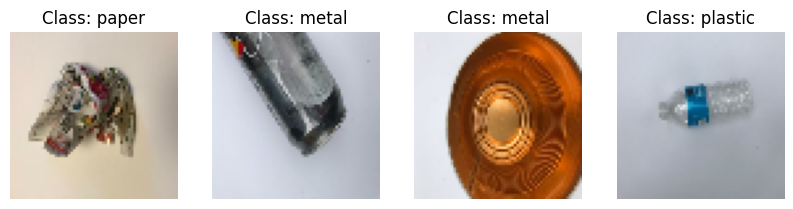

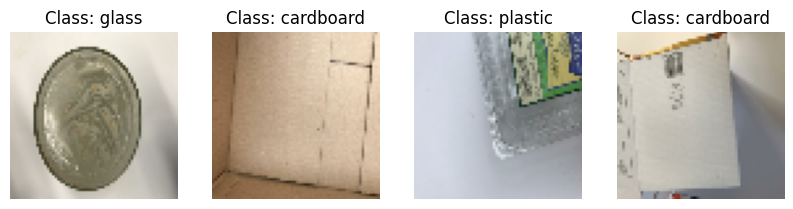

In [83]:
dataset_dir = "./dataset"
train = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    # label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    interpolation='bilinear',
    subset="training"
)
validate = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    # label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    interpolation='bilinear',
    subset="validation"
)

train_data = list(train)
train_images = np.concatenate([train_data[n][0] for n in range(0, len(train_data))])
train_labels = np.concatenate([train_data[n][1] for n in range(0, len(train_data))])

test_data = list(train)
test_images = np.concatenate([test_data[n][0] for n in range(0, len(test_data))])
test_labels = np.concatenate([test_data[n][1] for n in range(0, len(test_data))])


plt.figure(figsize=(10, 10))
for i in range(4):  # Display up to 9 images
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[i].astype("uint8"))
    plt.title(f"Class: {class_names[train_labels[i]]}")
    plt.axis("off")

plt.figure(figsize=(10, 10))
for i in range(4):  # Display up to 9 images
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[i].astype("uint8"))
    plt.title(f"Class: {class_names[test_labels[i]]}")
    plt.axis("off")



# Augment data

In [84]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
flip_layer = tf.keras.layers.RandomFlip("horizontal_and_vertical")
rotation_layer = tf.keras.layers.RandomRotation(0.2)
def change_inputs(images, labels):
    x = flip_layer(normalization_layer(images))
    x = rotation_layer(x)

    x = tf.image.resize(x, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return x, x


normalized_ds = train.map(change_inputs)
normalized_vds = validate.map(change_inputs)
# normalized_train_images = normalization_layer(train_images)
# flipped_train_images = np.array([np.fliplr(np.flipud(img)) for img in normalized_train_images])
# rotated_train_images = np.array([tf.image.rot90(img, k=np.random.choice([0, 1, 2, 3])) for img in flipped_train_images])

# resized_train_images = np.array([tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) for img in rotated_train_images])

# train_images = np.concatenate([train_images, resized_train_images])
# train_labels = np.concatenate([train_labels, train_labels])

# shuffle_indices = np.random.permutation(len(train_images))
# train_images = train_images[shuffle_indices]
# train_labels = train_labels[shuffle_indices]



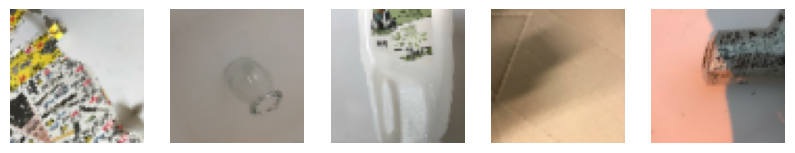

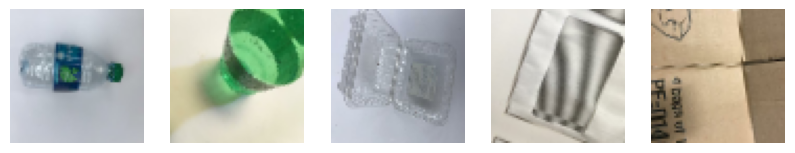

In [85]:

def plot_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):  # Take one batch for demonstration
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i].numpy() * 255).astype("uint8"))
            plt.axis("off")
    plt.show()

plot_images(normalized_ds)

# Plot augmented validation images
plot_images(normalized_vds)

In [86]:

# Autoencoder Model
def create_autoencoder_model():
    input_layer = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # perform downsampling, heading towards bottleneck
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck (no dropout here)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', )
    return autoencoder

# Training Autoencoder
autoencoder_model = create_autoencoder_model()
history_autoencoder = autoencoder_model.fit(normalized_ds, epochs=AUTOENCODER_EPOCHS)

# Encode data using the trained autoencoder
encoded_data = autoencoder_model.predict(normalized_vds)
print(f"Encoded Data Shape: {encoded_data.shape}")





Epoch 1/3
120/120 [==============================] - 28s 214ms/step - loss: 0.0123
Epoch 2/3
120/120 [==============================] - 26s 216ms/step - loss: 0.0054
Epoch 3/3
30/30 [==============================] - 3s 74ms/step
Encoded Data Shape: (478, 64, 64, 3)


In [ ]:
autoencoder_model.summary()
for i, layer in enumerate(autoencoder_model.layers):
  print(f"Layer {i}: {layer.name}")

In [ ]:

def create_classifier_model(autoencoder_model):
    # Use the encoder part of the autoencoder as a feature extractor
    encoder_output = autoencoder_model.layers[6].output  

    x = layers.Flatten()(encoder_output)
    x = layers.Dense(256, activation='relu')(x)  # Increase the number of units
    x = layers.Dropout(0.5)(x)  # Add dropout for regularization
    x = layers.Dense(256, activation='relu')(x)  # Increase the number of units
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)  # Increase the number of units
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    classifier_model = Model(autoencoder_model.input, output_layer)
    classifier_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier_model

# Pass your autoencoder model when creating the classifier
classifier_model = create_classifier_model(autoencoder_model)
history_classifier = classifier_model.fit(train, epochs=CLASSIFIER_EPOCHS, validation_data=validate)


# KFold cross validation

In [ ]:
num_folds = 5
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store results for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []

train_data = np.concatenate([x.numpy() for x, y in train], axis=0)
train_labels = np.concatenate([y.numpy() for x, y in train], axis=0)


for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(train_data, train_labels)):
    # Create and compile the model for each fold
    classifier_model = create_classifier_model(autoencoder_model)

    # Get the train and validation data for the current fold
    train_fold_data, val_fold_data = train_data[train_indices], train_data[val_indices]
    train_fold_labels, val_fold_labels = train_labels[train_indices], train_labels[val_indices]

    # Train the model for the current fold
    history_classifier = classifier_model.fit(
        train_fold_data, train_fold_labels,
        epochs=CLASSIFIER_EPOCHS,
        validation_data=(val_fold_data, val_fold_labels)
    )

    # Evaluate the model on the validation set
    val_predictions = classifier_model.predict(val_fold_data)
    val_pred_labels = np.argmax(val_predictions, axis=1)

    # Calculate and store metrics
    accuracy_scores.append(accuracy_score(val_fold_labels, val_pred_labels))
    precision_scores.append(precision_score(val_fold_labels, val_pred_labels, average='weighted'))
    recall_scores.append(recall_score(val_fold_labels, val_pred_labels, average='weighted'))

# Display average metrics across all folds
print(f"Average Accuracy: {np.mean(accuracy_scores)}")
print(f"Average Precision: {np.mean(precision_scores)}")
print(f"Average Recall: {np.mean(recall_scores)}")

In [ ]:
validate_normalized = validate.map(change_inputs)
validate_list = list(validate_normalized.as_numpy_iterator())
images_and_labels = list(validate.as_numpy_iterator())
# Predict labels for validation images
predictions = classifier_model.predict(validate)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)
y = np.concatenate([y for x, y in validate], axis=0)

# Display a few validation images along with their true and predicted labels
plt.figure(figsize=(10, 10))
for i in range(15):  # Adjust the number of images you want to display
    plt.subplot(4, 4, i + 1)
    
    # Access the batch of images and labels
    image_batch = images_and_labels[i][0]
    label_batch = images_and_labels[i][1]
    
    # Access the ith image and label from the batch
    image = image_batch[i]
    label = label_batch[i]
    
    plt.imshow(image.astype(np.uint8) / 255)
    plt.title(f"True: {class_names[label]}\nPredicted: {class_names[predicted_labels[i]]}")
    plt.axis('off')

plt.show()


1/1 [==============================] - 0s 108ms/step


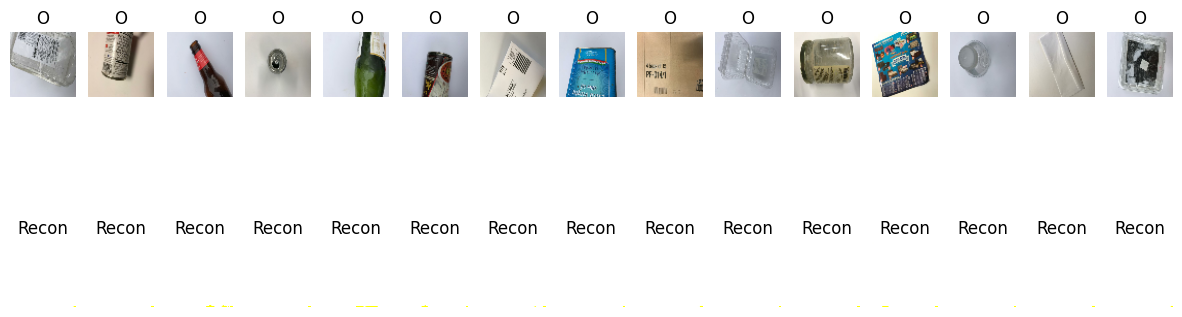

In [76]:
def get_validation_batch(dataset, batch_size=15):
    for images, _ in dataset.take(1):
        return images[:batch_size]

# Get a batch of images
sample_images = get_validation_batch(validate)
# Generate reconstructions
reconstructed_images = autoencoder_model.predict(sample_images)
plt.figure(figsize=(15, 5))
# Visualize original vs. reconstructed images
for i in range(len(sample_images)):
    plt.subplot(2, len(sample_images), i + 1)
    plt.imshow((sample_images[i]/255))
    plt.title("O")
    plt.axis("off")

    plt.subplot(2, len(sample_images), i + 1 + len(sample_images))
    plt.imshow((reconstructed_images[i] * 255).astype("uint8"))
    plt.title("Recon")
    plt.axis("off")

plt.show()

In [ ]:

autoencoder.summary()